# Imports

In [ ]:
!pip install -U scikit-activeml

In [ ]:
import pandas as pd
from sklearn.datasets import load_breast_cancer
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

from skactiveml.pool import UncertaintySampling
from skactiveml.pool import QueryByCommittee

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import BaggingClassifier
from skactiveml.classifier import SklearnClassifier, ParzenWindowClassifier

from skactiveml.utils import unlabeled_indices, labeled_indices, MISSING_LABEL
from skactiveml.visualization import plot_decision_boundary, plot_utilities

import warnings
mlp.rcParams["figure.facecolor"] = "white"
warnings.filterwarnings("ignore")

# Load and Prepare Data

In [ ]:
df = pd.read_csv('/content/healthcare-dataset-stroke-data.csv')
# Rename the 'stroke' column to 'target'
df = df.rename(columns={'stroke': 'target'})

In [ ]:
len(df)

5110

In [ ]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,target
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


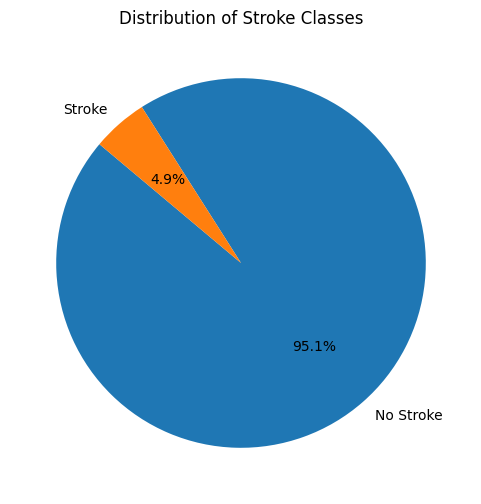

In [ ]:
target_counts = df['target'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(target_counts, labels=['No Stroke', 'Stroke'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Stroke Classes')
plt.show()

# Data Preprocessing

In [ ]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
target                 0
dtype: int64

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [ ]:
# Impute missing values in the 'bmi' column using mean imputation
imputer = SimpleImputer(strategy='mean')
df['bmi'] = imputer.fit_transform(df[['bmi']])

In [ ]:
# One-hot encode categorical variables using OneHotEncoder
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
encoded_features = pd.get_dummies(df[categorical_cols], columns=categorical_cols)

# Concatenate the encoded features with the original DataFrame
df = pd.concat([df, encoded_features], axis=1)
df.drop(columns=categorical_cols, inplace=True)

In [ ]:
# Scale numerical features using StandardScaler
scaler = StandardScaler()
numerical_cols = ['age', 'avg_glucose_level', 'bmi']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [ ]:
df.head().T

,0,1,2,3,4
id,9046.000000,5.167600e+04,31112.000000,60182.000000,1665.000000
age,1.051434,7.860701e-01,1.626390,0.255342,1.582163
hypertension,0.000000,0.000000e+00,0.000000,0.000000,1.000000
heart_disease,1.000000,0.000000e+00,1.000000,0.000000,0.000000
avg_glucose_level,2.706375,2.121559e+00,-0.005028,1.437358,1.501184
bmi,1.001234,4.615554e-16,0.468577,0.715418,-0.635711
target,1.000000,1.000000e+00,1.000000,1.000000,1.000000
gender_Female,0.000000,1.000000e+00,0.000000,1.000000,1.000000
gender_Male,1.000000,0.000000e+00,1.000000,0.000000,0.000000
gender_Other,0.000000,0.000000e+00,0.000000,0.000000,0.000000


In [ ]:
# # Change one-hot encoded columns to int
# encoded_to_convert = ['gender_Female', 'gender_Male', 'gender_Other',
#                       'ever_married_No', 'ever_married_Yes',
#                       'work_type_Govt_job', 'work_type_Never_worked',
#                       'work_type_Private', 'work_type_Self-employed', 'work_type_children',
#                       'Residence_type_Rural', 'Residence_type_Urban',
#                       'smoking_status_Unknown', 'smoking_status_formerly smoked',
#                       'smoking_status_never smoked', 'smoking_status_smokes']

# df[encoded_to_convert] = df[encoded_to_convert].astype(int)

# Entropy

In [ ]:
X = df.drop(columns=['target']).values
y_true = df['target'].values

y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)

In [ ]:
# clf_entropy = SklearnClassifier(LogisticRegression(), classes=np.unique(y_true))

clf_entropy = ParzenWindowClassifier(classes=np.unique(y_true), random_state=42)
# Initialise the query strategy.
qs_entropy = UncertaintySampling(method='entropy')

In [ ]:
# score on the before querie data.
y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)
clf_entropy.fit(X, y)

unqueried_score = clf_entropy.score(X,y_true)
print(unqueried_score)

0.5001956947162427


In [ ]:
performance_history_entropy = [unqueried_score]

In [ ]:
entropy_model = None

In [ ]:
n_cycles = 200
for c in range(n_cycles):
  # Fit the classifier.
  clf_entropy.fit(X, y)

  model_accuracy = clf_entropy.score(X,y_true)
  print(f'Query {c+1}: The accuracy score is {model_accuracy}.')

  # Get labeled instances.
  X_labeled = X[labeled_indices(y)]

  # Query the next instance/s.
  query_idx = qs_entropy.query(X=X, y=y, clf=clf_entropy)

  # Label the queried instances.
  y[query_idx] = y_true[query_idx]

  # Save our model's performance for plotting.
  performance_history_entropy.append(model_accuracy)

  entropy_model = clf_entropy

Query 1: The accuracy score is 0.5001956947162427.
Query 2: The accuracy score is 0.5015655577299413.
Query 3: The accuracy score is 0.5031311154598825.
Query 4: The accuracy score is 0.5021526418786693.
Query 5: The accuracy score is 0.5039138943248532.
Query 6: The accuracy score is 0.5056751467710372.
Query 7: The accuracy score is 0.5070450097847358.
Query 8: The accuracy score is 0.5099804305283757.
Query 9: The accuracy score is 0.5117416829745597.
Query 10: The accuracy score is 0.5129158512720157.
Query 11: The accuracy score is 0.5150684931506849.
Query 12: The accuracy score is 0.5164383561643836.
Query 13: The accuracy score is 0.5180039138943249.
Query 14: The accuracy score is 0.5205479452054794.
Query 15: The accuracy score is 0.5215264187866928.
Query 16: The accuracy score is 0.5230919765166341.
Query 17: The accuracy score is 0.5232876712328767.
Query 18: The accuracy score is 0.5252446183953033.
Query 19: The accuracy score is 0.5270058708414873.
Query 20: The accurac

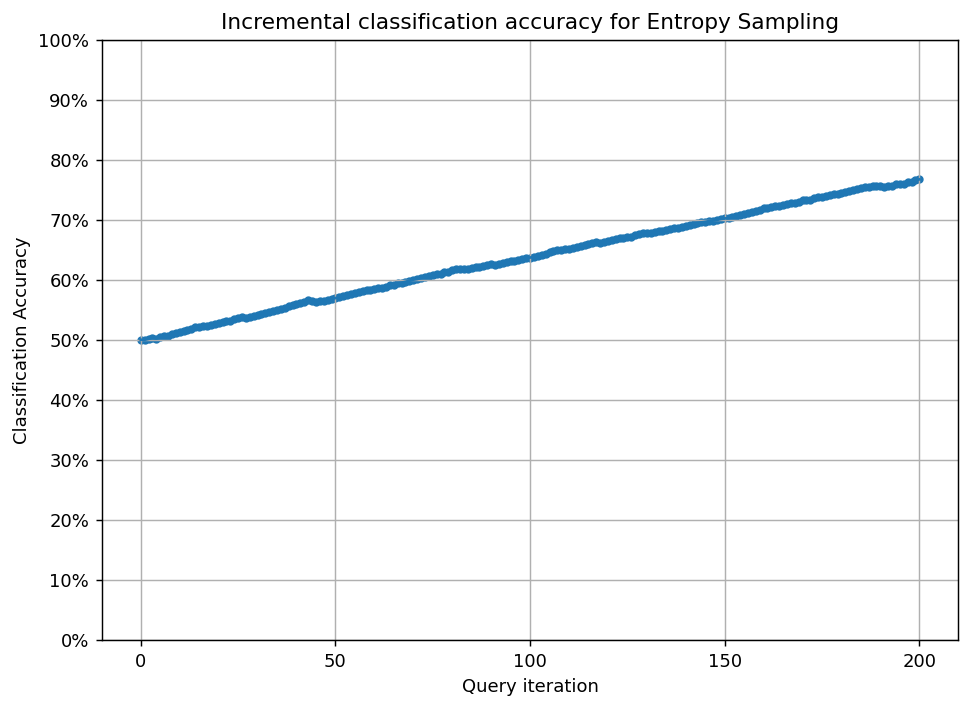

In [ ]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history_entropy)
ax.scatter(range(len(performance_history_entropy)), performance_history_entropy, s=13)

ax.xaxis.set_major_locator(mlp.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mlp.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mlp.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy for Entropy Sampling')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.79      0.86      4861
           1       0.05      0.22      0.08       249

    accuracy                           0.76      5110
   macro avg       0.50      0.50      0.47      5110
weighted avg       0.91      0.76      0.83      5110



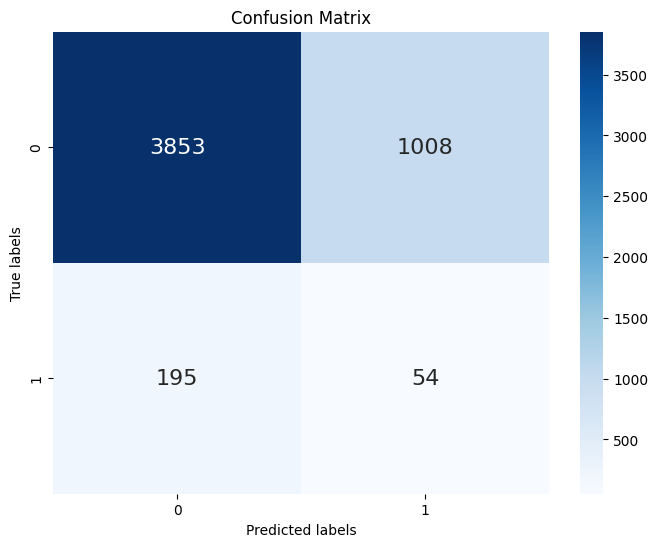

In [ ]:
y_true = df['target']
y_pred = entropy_model.predict(X)

# Compute classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", annot_kws={"size": 16})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Margin Sampling

In [ ]:
X = df.drop(columns=['target']).values
y_true = df['target'].values

y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)

In [ ]:
# clf_margin = SklearnClassifier(LogisticRegression(), classes=np.unique(y_true))

clf_margin = ParzenWindowClassifier(classes=np.unique(y_true), random_state=42)
# Initialise the query strategy.
qs_margin = UncertaintySampling(method='margin_sampling')

In [ ]:
# score on the before querie data.
y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)
clf_margin.fit(X, y)

unqueried_score = clf_margin.score(X,y_true)
print(unqueried_score)

0.5001956947162427


In [ ]:
performance_history_margin = [unqueried_score]

In [ ]:
margin_model = None

In [ ]:
n_cycles = 200
for c in range(n_cycles):
  # Fit the classifier.
  clf_margin.fit(X, y)

  model_accuracy = clf_margin.score(X,y_true)
  print(f'Query {c+1}: The accuracy score is {model_accuracy}.')

  # Get labeled instances.
  X_labeled = X[labeled_indices(y)]

  # Query the next instance/s.
  query_idx = qs_margin.query(X=X, y=y, clf=clf_margin)

  # Label the queried instances.
  y[query_idx] = y_true[query_idx]

  # Save our model's performance for plotting.
  performance_history_margin.append(model_accuracy)

  margin_model = clf_margin

Query 1: The accuracy score is 0.5001956947162427.
Query 2: The accuracy score is 0.5027397260273972.
Query 3: The accuracy score is 0.5037181996086105.
Query 4: The accuracy score is 0.5054794520547945.
Query 5: The accuracy score is 0.5062622309197652.
Query 6: The accuracy score is 0.5084148727984344.
Query 7: The accuracy score is 0.5097847358121331.
Query 8: The accuracy score is 0.510958904109589.
Query 9: The accuracy score is 0.5135029354207437.
Query 10: The accuracy score is 0.5144814090019569.
Query 11: The accuracy score is 0.5166340508806262.
Query 12: The accuracy score is 0.5187866927592955.
Query 13: The accuracy score is 0.5211350293542074.
Query 14: The accuracy score is 0.5234833659491194.
Query 15: The accuracy score is 0.525440313111546.
Query 16: The accuracy score is 0.5270058708414873.
Query 17: The accuracy score is 0.5295499021526419.
Query 18: The accuracy score is 0.5305283757338551.
Query 19: The accuracy score is 0.5318982387475538.
Query 20: The accuracy 

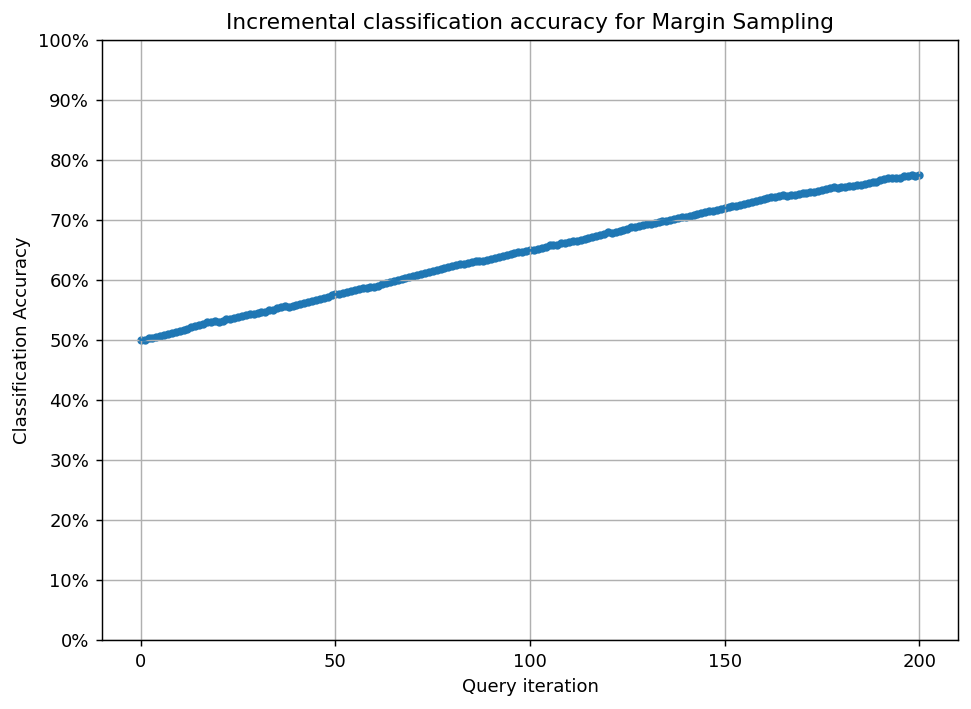

In [ ]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history_margin)
ax.scatter(range(len(performance_history_margin)), performance_history_margin, s=13)

ax.xaxis.set_major_locator(mlp.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mlp.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mlp.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy for Margin Sampling')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.80      0.87      4861
           1       0.05      0.18      0.07       249

    accuracy                           0.77      5110
   macro avg       0.50      0.49      0.47      5110
weighted avg       0.91      0.77      0.83      5110



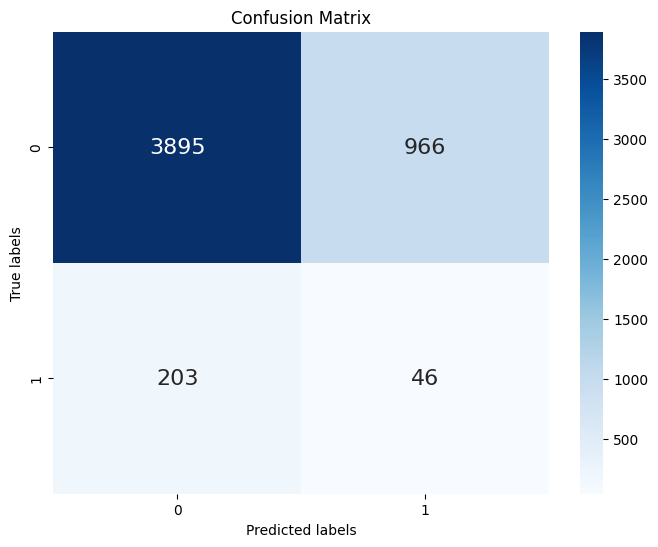

In [ ]:
y_true = df['target']
y_pred = margin_model.predict(X)

# Compute classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", annot_kws={"size": 16})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Query by Committee

In [ ]:
X = df.drop(columns=['target']).values
y_true = df['target'].values

y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)

In [ ]:
clf_committee = SklearnClassifier(BaggingClassifier(ParzenWindowClassifier()), classes=np.unique(y_true))

# Initialise the query strategy.
qs_committee = QueryByCommittee(random_state=42)

In [ ]:
# score on the before querie data.
y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)
clf_committee.fit(X, y)

unqueried_score = clf_committee.score(X,y_true)
print(unqueried_score)

0.4919765166340509


In [ ]:
performance_history_committee = [unqueried_score]

In [ ]:
committee_model = None

In [ ]:
n_cycles = 100
for c in range(n_cycles):
  # Fit the classifier.
  clf_committee.fit(X, y)

  model_accuracy = clf_committee.score(X,y_true)
  print(f'Query {c+1}: The accuracy score is {model_accuracy}.')

  # Get labeled instances.
  X_labeled = X[labeled_indices(y)]

  # Query the next instance/s.
  query_idx = qs_committee.query(X=X, y=y, ensemble=clf_committee)

  # Label the queried instances.
  y[query_idx] = y_true[query_idx]

  # Save our model's performance for plotting.
  performance_history_committee.append(model_accuracy)

  committee_model = clf_committee

Query 1: The accuracy score is 0.49471624266144815.
Query 2: The accuracy score is 0.9512720156555773.
Query 3: The accuracy score is 0.9473581213307241.
Query 4: The accuracy score is 0.9473581213307241.
Query 5: The accuracy score is 0.9495107632093933.
Query 6: The accuracy score is 0.9512720156555773.
Query 7: The accuracy score is 0.9504892367906067.
Query 8: The accuracy score is 0.9510763209393346.
Query 9: The accuracy score is 0.9512720156555773.
Query 10: The accuracy score is 0.9512720156555773.
Query 11: The accuracy score is 0.95146771037182.
Query 12: The accuracy score is 0.95146771037182.
Query 13: The accuracy score is 0.9512720156555773.
Query 14: The accuracy score is 0.95146771037182.
Query 15: The accuracy score is 0.95146771037182.
Query 16: The accuracy score is 0.95146771037182.
Query 17: The accuracy score is 0.95146771037182.
Query 18: The accuracy score is 0.9512720156555773.
Query 19: The accuracy score is 0.95146771037182.
Query 20: The accuracy score is 0.

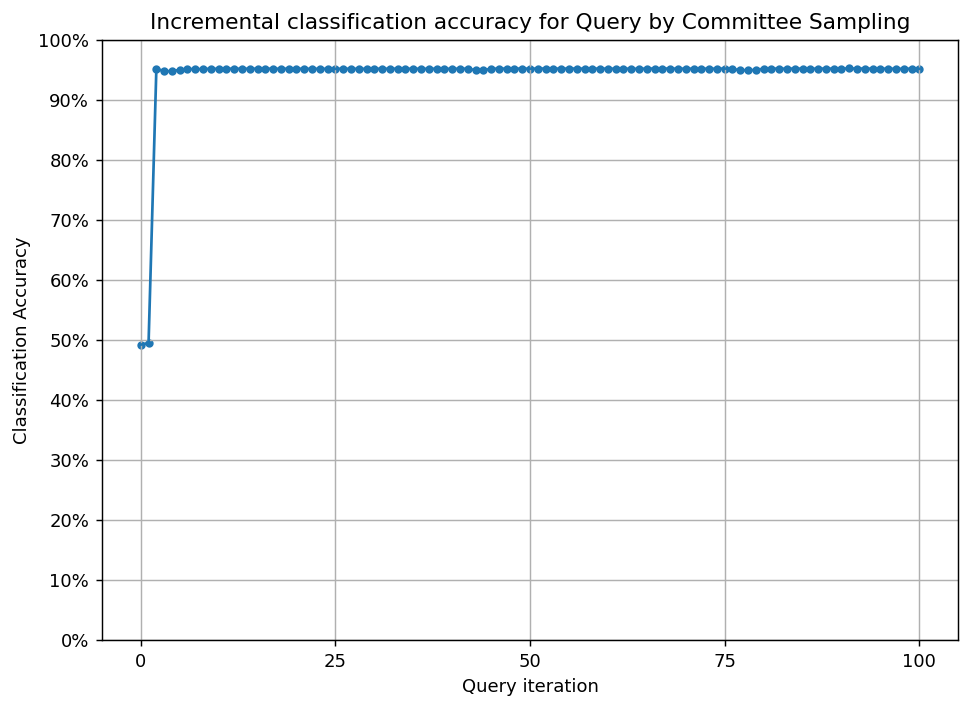

In [ ]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history_committee)
ax.scatter(range(len(performance_history_committee)), performance_history_committee, s=13)

ax.xaxis.set_major_locator(mlp.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mlp.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mlp.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy for Query by Committee Sampling')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      4861
           1       0.00      0.00      0.00       249

    accuracy                           0.95      5110
   macro avg       0.48      0.50      0.49      5110
weighted avg       0.90      0.95      0.93      5110



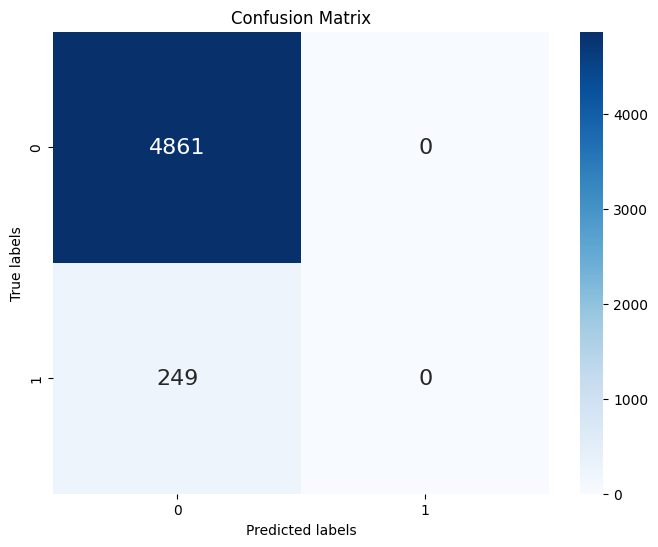

In [ ]:
y_true = df['target']
y_pred = committee_model.predict(X)

# Compute classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", annot_kws={"size": 16})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Save Models

In [ ]:
import joblib

# Save the classifier to a file
joblib.dump(committee_model, 'stroke_committee_model.pkl')
joblib.dump(margin_model, 'stroke_margin_model.pkl')
joblib.dump(entropy_model, 'stroke_entropy_model.pkl')

['stroke_entropy_model.pkl']